In [1]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataloader import default_collate

import time
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

In [2]:
# torch.cuda.empty_cache() полностью чистит память графического процессора

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224), antialias = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    # transforms.RandomAdjustSharpness(sharpness_factor=2),
    # transforms.RandomAutocontrast(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=35, translate=(0.3, 0.3))
    ])

BATCH_SIZE = 64
TEST_SIZE = 0.1

ROOT = ''
NET_NAME_1 = 'net_1_vgg.pt'
NET_NAME_2 = 'net_2_res.pt'
NET_NAME_3 = 'net_3_eff.pt'
DATASET_FOLDER = 'dataset_by_classes'
DATA_ROOT = DATASET_FOLDER

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [4]:
dataset = datasets.ImageFolder(DATASET_FOLDER, 
                               transform=transform)
classes = dataset.classes
classes

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '19',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '3

In [5]:
test_len = int(TEST_SIZE*len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, test_len])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, 
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
print(len(train_set),len(test_set))

6289 698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


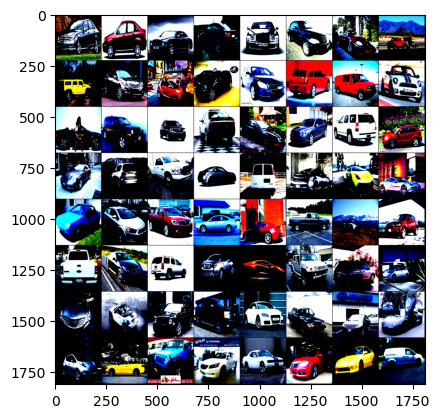

In [6]:
def imshow(img):
    img_np = img.cpu().numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break


In [7]:
def save_model(model, path, name):
  model_scripted = torch.jit.script(model)
  model_scripted.save(path + name)

In [8]:
def my_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {test_len} test images: {100 * correct // total} %')
    return 100 * correct // total

def my_accuracy_per_classes(model, test_loader, classes):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        if total_pred[classname] != 0:
            accuracy = 100 * float(correct_count) / total_pred[classname]
        else:
            accuracy = 0
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    return correct_pred.items()

In [9]:
def fit(model, train_dataloader, optim, criterion):
    model.train()
    train_running_loss = 0.0
    all_loss = []
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optim.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optim.step()
        
        train_running_loss += loss.item()
        all_loss.append(loss.item())
        if (i+1) % 3 == 0 :
          print((i+1), '/', len(train_dataloader.dataset) / BATCH_SIZE, ': loss = ', loss.item())
        
    mean_loss = train_running_loss/ (len(train_dataloader.dataset) / BATCH_SIZE)
    print(f'Mean epoch loss: {mean_loss:.4f}')
    
    return mean_loss, all_loss

#VGG16

In [10]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(DEVICE)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# меняем число выходов
vgg16.classifier[6].out_features = len(dataset.classes)

# замораживаем веса сверточных слоев
for param in vgg16.features.parameters():
    param.requires_grad = False

In [12]:
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.01)
# loss function
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 5

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()

9

In [14]:
epoch_mean_loss = []
all_loss = []
for epoch in range(MAX_EPOCHS): 
    mean_loss, epoch_losses = fit(vgg16, train_loader, optimizer, criterion)
    epoch_mean_loss.append(mean_loss)
    all_loss.extend(epoch_losses)
print('Finished Training')
save_model(vgg16, './', NET_NAME_1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 2.29 GiB already allocated; 0 bytes free; 3.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_mean_loss, color='green', label='train epoch losses')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(all_loss, color='green', label='train all losses')
plt.legend()
plt.show()

In [ ]:
my_accuracy(vgg16, test_loader)
my_accuracy_per_classes(vgg16, test_loader, classes)

NameError: ignored

In [ ]:
# for epoch in range(4): 
#     running_loss = 0.0
#     for j, data in enumerate(train_loader, 0):
#         inputs, labels = data

#         optimizer.zero_grad()

#         outputs = vgg16(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if j % 20 == 0: 
#             print(f'[{epoch + 1}, {j + 1:5d}] loss: {running_loss / 20:.3f}')
#             running_loss = 0.0
# print('Finished Training')
# save_model(vgg16, './', NET_NAME_1)

#ResNet50

In [36]:
# Инициализация модели
class MyResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.resnet50 = models.resnet50(pretrained=True)
        self.fc = nn.Linear(1000, 196)
        self.resnet50.requires_grad = False
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        self.resnet50.fc.requires_grad = True

    # Это forward функция, которая определяет структуру сети.
    # Здесь мы принимаем только один вход, но можно использовать больше.
    def forward(self, x):
        x = nn.functional.relu(self.resnet50(x))
        x = nn.functional.relu(self.fc(x))
        return x

In [37]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 196))

model.to(DEVICE)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
# optimizer
optimizer_resnet50 = optim.Adam(model.fc.parameters(), lr=0.0001)
# loss function
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 5

In [39]:
import gc
torch.cuda.empty_cache()
gc.collect()

3657

In [40]:
epoch_mean_loss = []
all_loss = []
for epoch in range(MAX_EPOCHS): 
    mean_loss, epoch_losses = fit(model, train_loader, optimizer_resnet50, criterion)
    epoch_mean_loss.append(mean_loss)
    all_loss.extend(epoch_losses)
print('Finished Training')
save_model(model, './', NET_NAME_2)

3 / 98.265625 : loss =  5.283189296722412
6 / 98.265625 : loss =  5.299633979797363
9 / 98.265625 : loss =  5.294492244720459
12 / 98.265625 : loss =  5.2722392082214355
15 / 98.265625 : loss =  5.248501300811768
18 / 98.265625 : loss =  5.297783851623535
21 / 98.265625 : loss =  5.243775367736816
24 / 98.265625 : loss =  5.2861409187316895
27 / 98.265625 : loss =  5.288124084472656
30 / 98.265625 : loss =  5.262413024902344
33 / 98.265625 : loss =  5.280119895935059
36 / 98.265625 : loss =  5.260047912597656
39 / 98.265625 : loss =  5.278861045837402
42 / 98.265625 : loss =  5.228862285614014
45 / 98.265625 : loss =  5.254087448120117
48 / 98.265625 : loss =  5.235013008117676
51 / 98.265625 : loss =  5.218791484832764
54 / 98.265625 : loss =  5.2204508781433105
57 / 98.265625 : loss =  5.187183856964111
60 / 98.265625 : loss =  5.184933662414551
63 / 98.265625 : loss =  5.241517066955566
66 / 98.265625 : loss =  5.2504377365112305
69 / 98.265625 : loss =  5.154452800750732
72 / 98.26

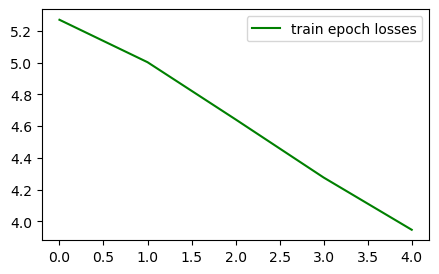

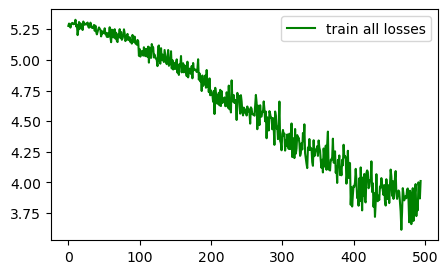

In [41]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_mean_loss, color='green', label='train epoch losses')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(all_loss, color='green', label='train all losses')
plt.legend()
plt.show()

In [43]:
my_accuracy(model, test_loader)
my_accuracy_per_classes(model, test_loader, classes)

Accuracy of the network on the 698 test images: 15 %
Accuracy for class: 1     is 50.0 %
Accuracy for class: 10    is 0.0 %
Accuracy for class: 100   is 0.0 %
Accuracy for class: 101   is 50.0 %
Accuracy for class: 102   is 0.0 %
Accuracy for class: 103   is 100.0 %
Accuracy for class: 104   is 0.0 %
Accuracy for class: 105   is 0.0 %
Accuracy for class: 106   is 0.0 %
Accuracy for class: 107   is 100.0 %
Accuracy for class: 108   is 75.0 %
Accuracy for class: 109   is 0.0 %
Accuracy for class: 11    is 20.0 %
Accuracy for class: 110   is 0.0 %
Accuracy for class: 111   is 0.0 %
Accuracy for class: 112   is 0.0 %
Accuracy for class: 113   is 0.0 %
Accuracy for class: 114   is 40.0 %
Accuracy for class: 115   is 0.0 %
Accuracy for class: 116   is 0.0 %
Accuracy for class: 117   is 0.0 %
Accuracy for class: 118   is 0.0 %
Accuracy for class: 119   is 100.0 %
Accuracy for class: 12    is 0.0 %
Accuracy for class: 120   is 0.0 %
Accuracy for class: 121   is 33.3 %
Accuracy for class: 122  

dict_items([('1', 1), ('10', 0), ('100', 0), ('101', 2), ('102', 0), ('103', 5), ('104', 0), ('105', 0), ('106', 0), ('107', 1), ('108', 3), ('109', 0), ('11', 1), ('110', 0), ('111', 0), ('112', 0), ('113', 0), ('114', 2), ('115', 0), ('116', 0), ('117', 0), ('118', 0), ('119', 5), ('12', 0), ('120', 0), ('121', 1), ('122', 1), ('123', 2), ('124', 0), ('125', 1), ('126', 0), ('127', 0), ('128', 1), ('129', 0), ('13', 0), ('130', 0), ('131', 0), ('132', 0), ('133', 0), ('134', 0), ('135', 0), ('136', 0), ('137', 0), ('138', 0), ('139', 0), ('14', 0), ('140', 0), ('141', 0), ('142', 0), ('143', 0), ('144', 1), ('145', 2), ('146', 1), ('147', 1), ('148', 0), ('149', 0), ('15', 0), ('150', 0), ('151', 1), ('152', 1), ('153', 2), ('154', 2), ('155', 0), ('156', 1), ('157', 0), ('158', 0), ('159', 0), ('16', 0), ('160', 1), ('161', 3), ('162', 3), ('163', 1), ('164', 0), ('165', 1), ('166', 2), ('167', 0), ('168', 2), ('169', 0), ('17', 0), ('170', 0), ('171', 0), ('172', 1), ('173', 0), ('

EfficientNet

In [10]:
model = models.efficientnet_b7(pretrained=True)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [11]:
for param in model.parameters():
    param.requires_grad = False   
    
model.classifier[1] = nn.Sequential(
               nn.Linear(2560, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 196))

model.to(DEVICE)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [12]:
# optimizer
optimizer_eff = optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 5

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()

9

In [14]:
epoch_mean_loss = []
all_loss = []
for epoch in range(MAX_EPOCHS): 
    mean_loss, epoch_losses = fit(model, train_loader, optimizer_eff, criterion)
    epoch_mean_loss.append(mean_loss)
    all_loss.extend(epoch_losses)
print('Finished Training')
save_model(model, './', NET_NAME_3)

3 / 98.265625 : loss =  5.2830986976623535
6 / 98.265625 : loss =  5.299757480621338
9 / 98.265625 : loss =  5.261325836181641
12 / 98.265625 : loss =  5.277106285095215
15 / 98.265625 : loss =  5.2516255378723145
18 / 98.265625 : loss =  5.351428508758545
21 / 98.265625 : loss =  5.212712287902832
24 / 98.265625 : loss =  5.26517915725708
27 / 98.265625 : loss =  5.265603065490723
30 / 98.265625 : loss =  5.246708869934082
33 / 98.265625 : loss =  5.2250142097473145
36 / 98.265625 : loss =  5.263514518737793
39 / 98.265625 : loss =  5.2218337059021
42 / 98.265625 : loss =  5.139186382293701
45 / 98.265625 : loss =  5.174952030181885
48 / 98.265625 : loss =  5.094352722167969
51 / 98.265625 : loss =  5.228585720062256
54 / 98.265625 : loss =  5.117609024047852
57 / 98.265625 : loss =  5.021905899047852
60 / 98.265625 : loss =  5.059926509857178
63 / 98.265625 : loss =  4.960585594177246
66 / 98.265625 : loss =  4.988409996032715
69 / 98.265625 : loss =  5.0308942794799805
72 / 98.26562

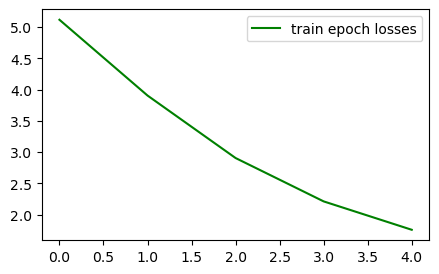

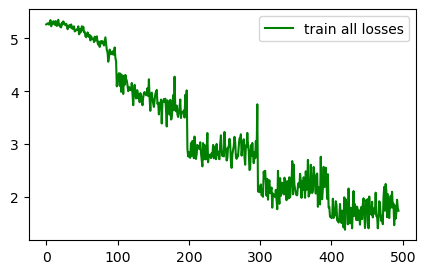

In [15]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_mean_loss, color='green', label='train epoch losses')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(all_loss, color='green', label='train all losses')
plt.legend()
plt.show()

In [16]:
my_accuracy(model, test_loader)
my_accuracy_per_classes(model, test_loader, classes)

Accuracy of the network on the 698 test images: 17 %
Accuracy for class: 1     is 100.0 %
Accuracy for class: 10    is 0.0 %
Accuracy for class: 100   is 60.0 %
Accuracy for class: 101   is 20.0 %
Accuracy for class: 102   is 0.0 %
Accuracy for class: 103   is 0.0 %
Accuracy for class: 104   is 100.0 %
Accuracy for class: 105   is 50.0 %
Accuracy for class: 106   is 0.0 %
Accuracy for class: 107   is 0.0 %
Accuracy for class: 108   is 33.3 %
Accuracy for class: 109   is 0.0 %
Accuracy for class: 11    is 66.7 %
Accuracy for class: 110   is 16.7 %
Accuracy for class: 111   is 100.0 %
Accuracy for class: 112   is 12.5 %
Accuracy for class: 113   is 0.0 %
Accuracy for class: 114   is 50.0 %
Accuracy for class: 115   is 0.0 %
Accuracy for class: 116   is 33.3 %
Accuracy for class: 117   is 66.7 %
Accuracy for class: 118   is 0.0 %
Accuracy for class: 119   is 50.0 %
Accuracy for class: 12    is 0.0 %
Accuracy for class: 120   is 0.0 %
Accuracy for class: 121   is 50.0 %
Accuracy for class:

dict_items([('1', 1), ('10', 0), ('100', 3), ('101', 1), ('102', 0), ('103', 0), ('104', 1), ('105', 3), ('106', 0), ('107', 0), ('108', 1), ('109', 0), ('11', 2), ('110', 1), ('111', 1), ('112', 1), ('113', 0), ('114', 1), ('115', 0), ('116', 2), ('117', 2), ('118', 0), ('119', 2), ('12', 0), ('120', 0), ('121', 1), ('122', 0), ('123', 0), ('124', 1), ('125', 0), ('126', 1), ('127', 0), ('128', 0), ('129', 0), ('13', 0), ('130', 0), ('131', 1), ('132', 0), ('133', 0), ('134', 0), ('135', 0), ('136', 0), ('137', 0), ('138', 1), ('139', 0), ('14', 0), ('140', 0), ('141', 0), ('142', 0), ('143', 0), ('144', 0), ('145', 0), ('146', 2), ('147', 0), ('148', 0), ('149', 1), ('15', 0), ('150', 3), ('151', 2), ('152', 1), ('153', 1), ('154', 2), ('155', 2), ('156', 1), ('157', 2), ('158', 0), ('159', 0), ('16', 2), ('160', 1), ('161', 1), ('162', 0), ('163', 1), ('164', 0), ('165', 0), ('166', 1), ('167', 0), ('168', 2), ('169', 2), ('17', 1), ('170', 1), ('171', 0), ('172', 1), ('173', 2), ('